In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import solve_banded

def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    """Compute the Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def black_scholes_delta(S, K, T, r, sigma, option_type="call"):
    """Compute the Black-Scholes Delta."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == "call":
        return norm.cdf(d1)
    elif option_type == "put":
        return norm.cdf(d1) - 1
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

def black_scholes_gamma(S, K, T, r, sigma):
    """Compute the Black-Scholes Gamma."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call", M=200, N=200):
    """Solve the bounded Black-Scholes equation using the Finite Difference Method (FDM)."""
    dS = (S_max - S_min) / M  # Stock price step
    dt = T / N  # Time step
    S_vals = np.linspace(S_min, S_max, M+1)
    
    # Initialize option price grid
    if option_type == "call":
        V = np.maximum(S_vals - K, 0)  # Payoff at maturity for a call
    elif option_type == "put":
        V = np.maximum(K - S_vals, 0)  # Payoff at maturity for a put
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    V = np.tile(V, (N+1, 1)).T  # Replicate for all time steps
    
    # Crank-Nicolson coefficients
    alpha = 0.25 * sigma**2 * (S_vals[1:-1]**2) / dS**2
    beta = 0.25 * r * S_vals[1:-1] / dS
    
    A = -alpha + beta
    B = 1/dt + 2*alpha + r/2
    C = -alpha - beta
    
    # Tridiagonal system setup
    lower_diag = np.zeros(M-2)
    main_diag = np.zeros(M-1)
    upper_diag = np.zeros(M-2)
    
    lower_diag[:] = A[1:]
    main_diag[:] = B
    upper_diag[:] = C[:-1]
    
    # Backward induction with Crank-Nicolson
    for n in range(N-1, -1, -1):
        rhs = V[1:-1, n+1] / dt
        rhs[0] -= A[0] * V[0, n+1]  # Neumann BC at S_min
        rhs[-1] -= C[-1] * V[-1, n+1]  # Neumann BC at S_max
        
        # Solve tridiagonal system
        A_matrix = np.zeros((3, M-1))
        A_matrix[0, 1:] = upper_diag
        A_matrix[1, :] = main_diag
        A_matrix[2, :-1] = lower_diag
        
        V[1:-1, n] = solve_banded((1, 1), A_matrix, rhs)
        
        # Apply Neumann BCs
        V[0, n] = V[1, n]
        V[-1, n] = V[-2, n]       

    V_S0 = V[np.argmin(np.abs(S_vals - S0)), 0]  # Extract price at S0
    
    # Compute FDM Delta and Gamma using finite differences
    delta_fdm = np.gradient(V[:, 0], dS)
    gamma_fdm = np.gradient(delta_fdm, dS)
    
    return S_vals, V[:, 0], V_S0, delta_fdm, gamma_fdm

# Delta, Gamma

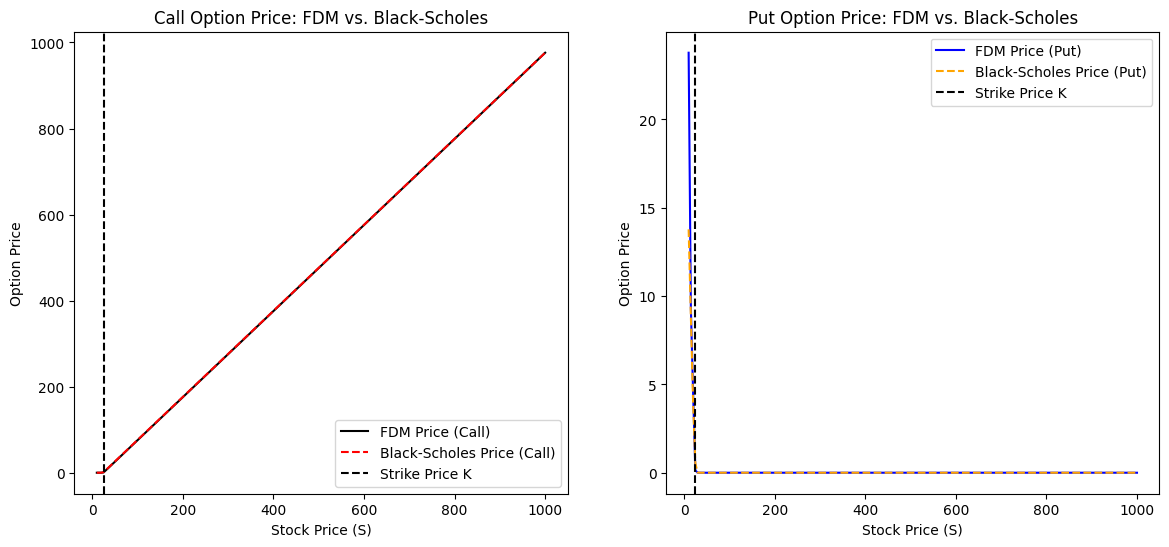

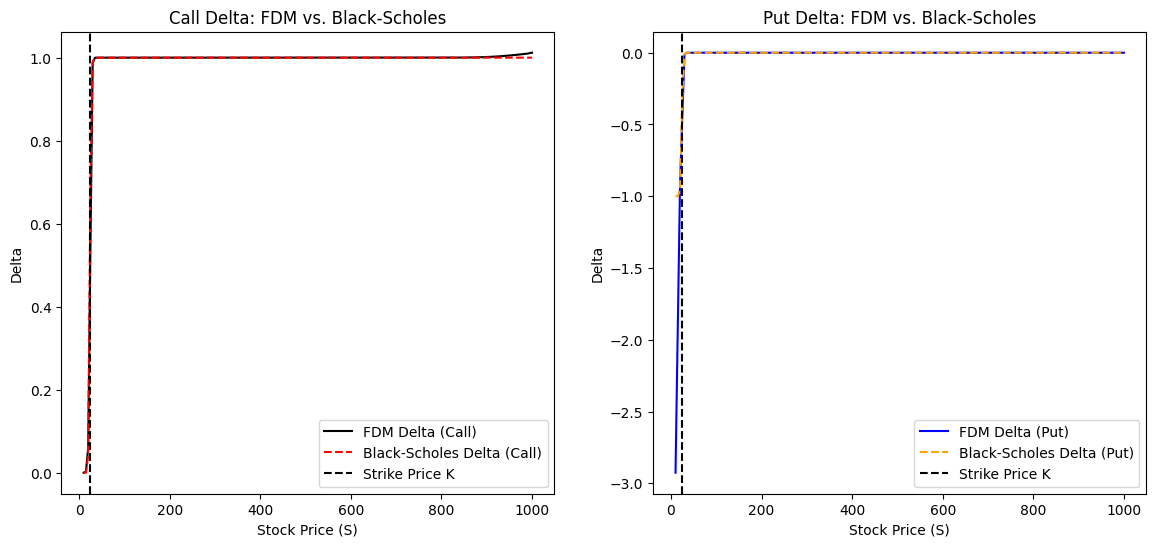

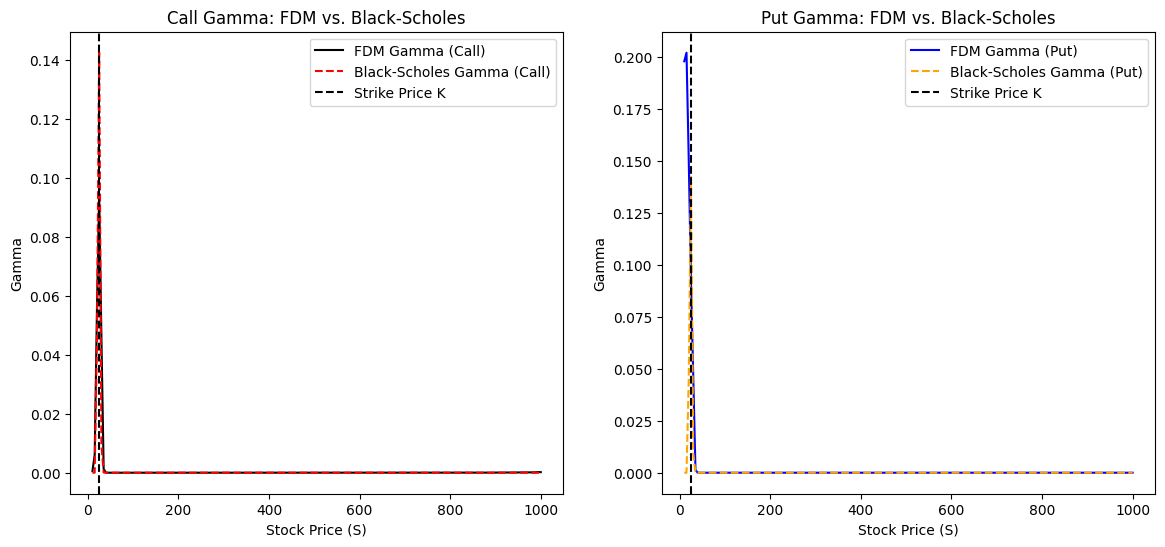

In [116]:
# Parameters
S0 = 25  # Initial stock price
S_min, S_max = 10, 1000  # Bounded domain
K = 25  # Strike price
T = 1   # Time to expiry
r = 0.05  # Risk-free rate
sigma = 0.1  # Volatility

# Compute FDM prices for both Call and Put options
S_vals, V_fdm_call, _, delta_fdm_call, gamma_fdm_call = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call")
S_vals, V_fdm_put, _, delta_fdm_put, gamma_fdm_put = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="put")

# Compute Black-Scholes prices and Greeks for Calls and Puts
bs_prices_call = np.array([black_scholes_price(S, K, T, r, sigma, option_type="call") for S in S_vals])
bs_prices_put = np.array([black_scholes_price(S, K, T, r, sigma, option_type="put") for S in S_vals])

delta_bs_call = np.array([black_scholes_delta(S, K, T, r, sigma, option_type="call") for S in S_vals])
delta_bs_put = np.array([black_scholes_delta(S, K, T, r, sigma, option_type="put") for S in S_vals])

gamma_bs = np.array([black_scholes_gamma(S, K, T, r, sigma) for S in S_vals])  # Gamma is the same for call & put

# --- Plot Option Prices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Call Option Price
axes[0].plot(S_vals, V_fdm_call, label="FDM Price (Call)", linestyle="solid", color="black")
axes[0].plot(S_vals, bs_prices_call, label="Black-Scholes Price (Call)", linestyle="dashed", color="red")
axes[0].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[0].set_xlabel("Stock Price (S)")
axes[0].set_ylabel("Option Price")
axes[0].set_title("Call Option Price: FDM vs. Black-Scholes")
axes[0].legend()

# Put Option Price
axes[1].plot(S_vals, V_fdm_put, label="FDM Price (Put)", linestyle="solid", color="blue")
axes[1].plot(S_vals, bs_prices_put, label="Black-Scholes Price (Put)", linestyle="dashed", color="orange")
axes[1].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[1].set_xlabel("Stock Price (S)")
axes[1].set_ylabel("Option Price")
axes[1].set_title("Put Option Price: FDM vs. Black-Scholes")
axes[1].legend()

plt.show()

# --- Plot Delta ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Call Delta
axes[0].plot(S_vals, delta_fdm_call, label="FDM Delta (Call)", linestyle="solid", color="black")
axes[0].plot(S_vals, delta_bs_call, label="Black-Scholes Delta (Call)", linestyle="dashed", color="red")
axes[0].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[0].set_xlabel("Stock Price (S)")
axes[0].set_ylabel("Delta")
axes[0].set_title("Call Delta: FDM vs. Black-Scholes")
axes[0].legend()

# Put Delta
axes[1].plot(S_vals, delta_fdm_put, label="FDM Delta (Put)", linestyle="solid", color="blue")
axes[1].plot(S_vals, delta_bs_put, label="Black-Scholes Delta (Put)", linestyle="dashed", color="orange")
axes[1].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[1].set_xlabel("Stock Price (S)")
axes[1].set_ylabel("Delta")
axes[1].set_title("Put Delta: FDM vs. Black-Scholes")
axes[1].legend()

plt.show()

# --- Plot Gamma ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Call Gamma
axes[0].plot(S_vals, gamma_fdm_call, label="FDM Gamma (Call)", linestyle="solid", color="black")
axes[0].plot(S_vals, gamma_bs, label="Black-Scholes Gamma (Call)", linestyle="dashed", color="red")
axes[0].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[0].set_xlabel("Stock Price (S)")
axes[0].set_ylabel("Gamma")
axes[0].set_title("Call Gamma: FDM vs. Black-Scholes")
axes[0].legend()

# Put Gamma
axes[1].plot(S_vals, gamma_fdm_put, label="FDM Gamma (Put)", linestyle="solid", color="blue")
axes[1].plot(S_vals, gamma_bs, label="Black-Scholes Gamma (Put)", linestyle="dashed", color="orange")
axes[1].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[1].set_xlabel("Stock Price (S)")
axes[1].set_ylabel("Gamma")
axes[1].set_title("Put Gamma: FDM vs. Black-Scholes")
axes[1].legend()

plt.show()

# Very high and low vol

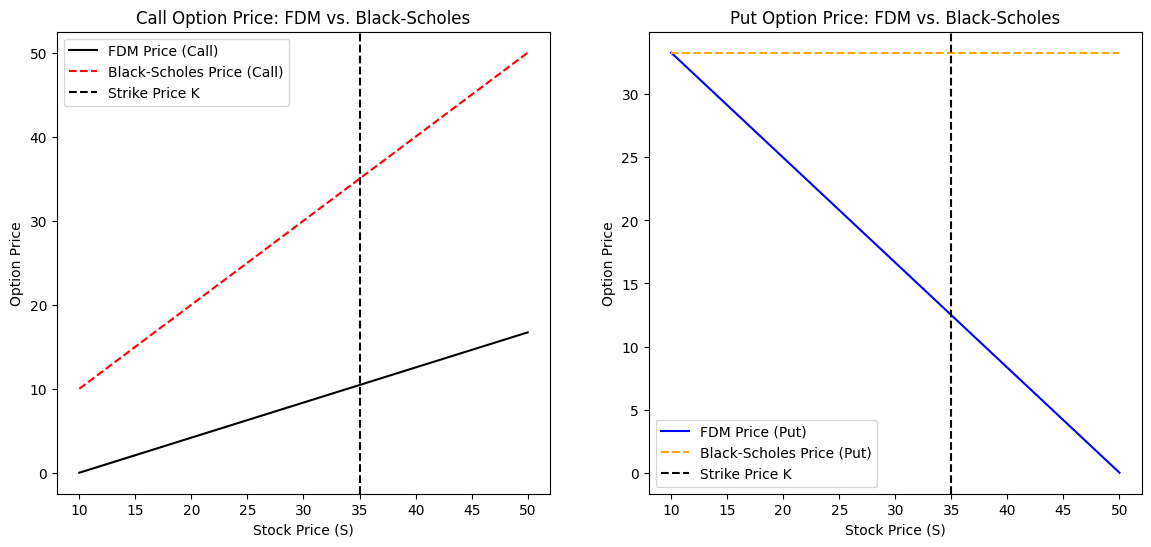

In [117]:
# Parameters
S0 = 25  # Initial stock price
S_min, S_max = 10, 50  # Bounded domain
K = 35  # Strike price
T = 1   # Time to expiry
r = 0.05  # Risk-free rate
sigma = 10000  # Volatility

# Compute FDM prices for both Call and Put options
S_vals, V_fdm_call, _, delta_fdm_call, gamma_fdm_call = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call")
S_vals, V_fdm_put, _, delta_fdm_put, gamma_fdm_put = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="put")

# Compute Black-Scholes prices and Greeks for Calls and Puts
bs_prices_call = np.array([black_scholes_price(S, K, T, r, sigma, option_type="call") for S in S_vals])
bs_prices_put = np.array([black_scholes_price(S, K, T, r, sigma, option_type="put") for S in S_vals])

# --- Plot Option Prices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Call Option Price
axes[0].plot(S_vals, V_fdm_call, label="FDM Price (Call)", linestyle="solid", color="black")
axes[0].plot(S_vals, bs_prices_call, label="Black-Scholes Price (Call)", linestyle="dashed", color="red")
axes[0].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[0].set_xlabel("Stock Price (S)")
axes[0].set_ylabel("Option Price")
axes[0].set_title("Call Option Price: FDM vs. Black-Scholes")
axes[0].legend()

# Put Option Price
axes[1].plot(S_vals, V_fdm_put, label="FDM Price (Put)", linestyle="solid", color="blue")
axes[1].plot(S_vals, bs_prices_put, label="Black-Scholes Price (Put)", linestyle="dashed", color="orange")
axes[1].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[1].set_xlabel("Stock Price (S)")
axes[1].set_ylabel("Option Price")
axes[1].set_title("Put Option Price: FDM vs. Black-Scholes")
axes[1].legend()

plt.show()

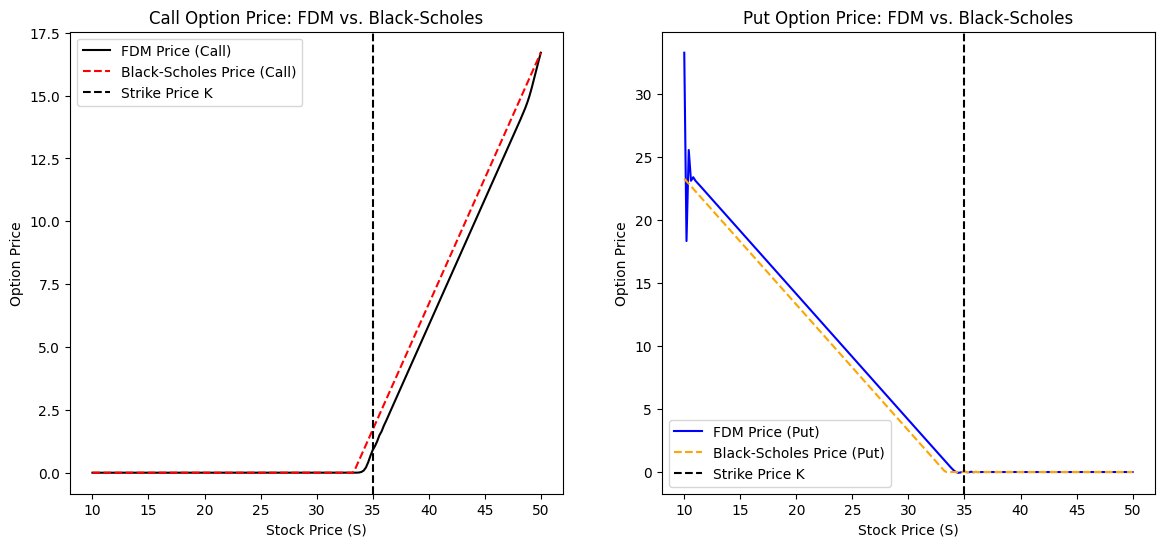

In [118]:
# Parameters
S0 = 25  # Initial stock price
S_min, S_max = 10, 50  # Bounded domain
K = 35  # Strike price
T = 1   # Time to expiry
r = 0.05  # Risk-free rate
sigma = 0.000001 # Volatility

# Compute FDM prices for both Call and Put options
S_vals, V_fdm_call, _, delta_fdm_call, gamma_fdm_call = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call")
S_vals, V_fdm_put, _, delta_fdm_put, gamma_fdm_put = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="put")

# Compute Black-Scholes prices and Greeks for Calls and Puts
bs_prices_call = np.array([black_scholes_price(S, K, T, r, sigma, option_type="call") for S in S_vals])
bs_prices_put = np.array([black_scholes_price(S, K, T, r, sigma, option_type="put") for S in S_vals])

# --- Plot Option Prices ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Call Option Price
axes[0].plot(S_vals, V_fdm_call, label="FDM Price (Call)", linestyle="solid", color="black")
axes[0].plot(S_vals, bs_prices_call, label="Black-Scholes Price (Call)", linestyle="dashed", color="red")
axes[0].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[0].set_xlabel("Stock Price (S)")
axes[0].set_ylabel("Option Price")
axes[0].set_title("Call Option Price: FDM vs. Black-Scholes")
axes[0].legend()

# Put Option Price
axes[1].plot(S_vals, V_fdm_put, label="FDM Price (Put)", linestyle="solid", color="blue")
axes[1].plot(S_vals, bs_prices_put, label="Black-Scholes Price (Put)", linestyle="dashed", color="orange")
axes[1].axvline(K, color="k", linestyle="--", label="Strike Price K")
axes[1].set_xlabel("Stock Price (S)")
axes[1].set_ylabel("Option Price")
axes[1].set_title("Put Option Price: FDM vs. Black-Scholes")
axes[1].legend()

plt.show()

# Surfaces

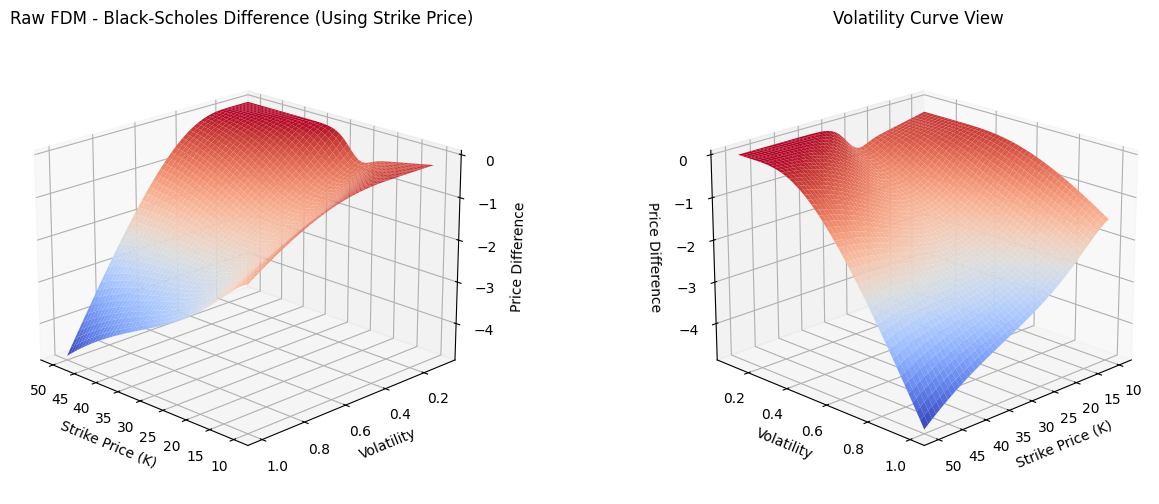

In [119]:
# Define fixed parameters
S0 = 25  # Initial stock price
S_min, S_max = 10, 50  # Bounded domain
T = 1   # Time to expiry
r = 0.05  # Risk-free rate

# Define parameter ranges
strike_prices = np.linspace(10, 50, 50)  # Range of strikes
volatilities = np.linspace(0.1, 1, 50)  # Range of volatilities
K_grid, V_grid = np.meshgrid(strike_prices, volatilities)

# Compute FDM and Black-Scholes prices
fdm_prices_surface = np.array([[finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, "call")[2]
                                 for K in strike_prices] for sigma in volatilities])

bs_prices_surface = np.array([[black_scholes_price(S0, K, T, r, sigma, "call")
                                for K in strike_prices] for sigma in volatilities])

# Compute price differences
price_difference_surface = fdm_prices_surface - bs_prices_surface

# Plot the raw FDM - Black-Scholes difference using strike price
fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

# First subplot: Original difference surface
axes[0].plot_surface(K_grid, V_grid, price_difference_surface, cmap='coolwarm', edgecolor='none')
axes[0].view_init(elev=20, azim=135)
axes[0].set_title("Raw FDM - Black-Scholes Difference (Using Strike Price)")
axes[0].set_xlabel("Strike Price (K)")
axes[0].set_ylabel("Volatility")
axes[0].set_zlabel("Price Difference")

# Second subplot: View from 180 degrees
axes[1].plot_surface(K_grid, V_grid, price_difference_surface, cmap='coolwarm', edgecolor='none')
axes[1].view_init(elev=20, azim=45)
axes[1].set_title("Volatility Curve View")
axes[1].set_xlabel("Strike Price (K)")
axes[1].set_ylabel("Volatility")
axes[1].set_zlabel("Price Difference")

plt.show()

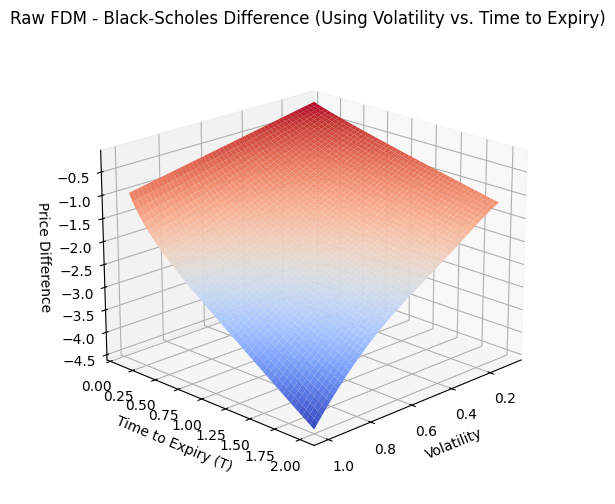

In [120]:
# Define fixed parameters
S0 = 25  # Initial stock price
S_min, S_max = 10, 50  # Bounded domain
r = 0.05  # Risk-free rate
K = 25  # Strike price

# Define parameter range for time to expiry
maturities = np.linspace(0.1, 2, 50)  # Range of times to expiry
volatilities = np.linspace(0.1, 1, 50)  # Range of volatilities
V_grid, T_grid = np.meshgrid(volatilities, maturities)

# Compute FDM and Black-Scholes prices for volatility vs. time to expiry
fdm_prices_time_surface = np.array([[finite_difference_black_scholes(S0, S_min, S_max, K, T_, r, v, "call")[2]
                                      for v in volatilities] for T_ in maturities])

bs_prices_time_surface = np.array([[black_scholes_price(S0, K, T_, r, v, "call")
                                     for v in volatilities] for T_ in maturities])

# Compute price differences for volatility vs. time to expiry
price_difference_time_surface = fdm_prices_time_surface - bs_prices_time_surface

# Plot the raw FDM - Black-Scholes difference using volatility vs. time to expiry
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})
ax.plot_surface(V_grid, T_grid, price_difference_time_surface, cmap='coolwarm', edgecolor='none')
ax.view_init(elev=20, azim=45)
ax.set_title("Raw FDM - Black-Scholes Difference (Using Volatility vs. Time to Expiry)")
ax.set_xlabel("Volatility")
ax.set_ylabel("Time to Expiry (T)")
ax.set_zlabel("Price Difference")

plt.show()

# Convergence to BS

C:\Users\faris\AppData\Local\Temp\ipykernel_22264\3209451569.py:8: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


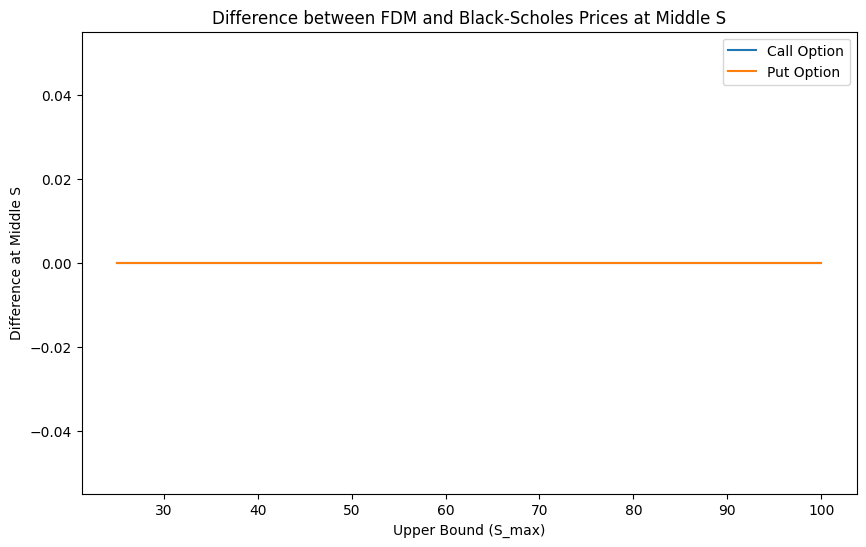

In [126]:
# Parameters
S0 = 25  # Initial stock price
S_min = 0 # Lower bound
K = 25  # Strike price
T = 1   # Time to expiry
r = 0.05  # Risk-free rate
sigma = 0.1  # Volatility

S_max_vals = np.linspace(25, 100, 100)  # Range of upper bounds
diffs = []  # Store differences

for S_max in S_max_vals:
    # Compute FDM prices for both Call and Put options
    S_vals, V_fdm_call, _, _, _ = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="call")
    S_vals, V_fdm_put, _, _, _ = finite_difference_black_scholes(S0, S_min, S_max, K, T, r, sigma, option_type="put")

    # Find the middle index of the stock price array
    middle_idx = len(S_vals) // 2
    middle_S = S_vals[0]

    # Calculate difference between BS and FDM prices for the middle stock price
    bs_price_call = black_scholes_price(middle_S, K, T, r, sigma, option_type="call")
    bs_price_put = black_scholes_price(middle_S, K, T, r, sigma, option_type="put")

    diff_call = V_fdm_call[0] - bs_price_call
    diff_put = V_fdm_put[0] - bs_price_put
    diffs.append((diff_call, diff_put))

diffs = np.array(diffs)

# Plot the differences
plt.figure(figsize=(10, 6))
plt.plot(S_max_vals, diffs[:, 0], label="Call Option")
plt.plot(S_max_vals, diffs[:, 1], label="Put Option")
plt.xlabel("Upper Bound (S_max)")
plt.ylabel("Difference at Middle S")
plt.title("Difference between FDM and Black-Scholes Prices at Middle S")
plt.legend()
plt.show()
